In [1]:
# imports
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from IPython.display import display
# IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400,400
from __future__ import division
from __future__ import unicode_literals
from pkasolver.ml_architecture import GINPairV1, GINPairV2
from pkasolver.ml import (
    dataset_to_dataloader,
    calc_testset_performace,
    calculate_performance_of_model_on_data,
    predict
)
from pkasolver.data import calculate_nr_of_features, mol_to_paired_mol_data, make_features_dicts
import torch
import torch_geometric
from copy import deepcopy
from rdkit.Chem import Draw
from pkasolver.constants import EDGE_FEATURES, NODE_FEATURES, DEVICE

    
# paths and constants
smarts_file = "smarts_pattern.tsv"
node_feat_list = [
    "element",
    "formal_charge",
    "hybridization",
    "total_num_Hs",
    "aromatic_tag",
    "total_valence",
    "total_degree",
    "is_in_ring",
    "reaction_center",
    "smarts",
]

edge_feat_list = ["bond_type", "is_conjugated", "rotatable"]
num_node_features = calculate_nr_of_features(node_feat_list)
num_edge_features = calculate_nr_of_features(edge_feat_list)

# make dicts from selection list to be used in the processing step
selected_node_features = make_features_dicts(NODE_FEATURES, node_feat_list)
selected_edge_features = make_features_dicts(EDGE_FEATURES, edge_feat_list)

model_path = "/data/shared/projects/pkasolver-data-clean/trained_models_v0/training_with_GINPairV1_v0_hp/pretrained_best_model.pt"

# helper functions

def split_acid_base_pattern(smarts_file): # from molGpka
    df_smarts = pd.read_csv(smarts_file, sep="\t")
    df_smarts_acid = df_smarts[df_smarts.Acid_or_base == "A"]
    df_smarts_base = df_smarts[df_smarts.Acid_or_base == "B"]
    return df_smarts_acid, df_smarts_base
    
def unique_acid_match(matches):     # from molGpka
    single_matches = list(set([m[0] for m in matches if len(m)==1]))
    double_matches = [m for m in matches if len(m)==2]
    single_matches = [[j] for j in single_matches]
    double_matches.extend(single_matches)
    return double_matches

def match_acid(df_smarts_acid, mol):     # from molGpka
    matches = []
    for idx, name, smarts, index, acid_base in df_smarts_acid.itertuples():
        pattern = Chem.MolFromSmarts(smarts)
        match = mol.GetSubstructMatches(pattern)
        if len(match) == 0:
            continue
        if len(index) > 2:
            index = index.split(",")
            index = [int(i) for i in index]
            for m in match:
                matches.append([m[index[0]], m[index[1]]])
        else:
            index = int(index)
            for m in match:
                matches.append([m[index]])
    matches = unique_acid_match(matches)
    matches_modify = []
    for i in matches:
        for j in i:
            matches_modify.append(j)
    return matches_modify

def match_base(df_smarts_base, mol):     # from molGpka
    matches = []
    for idx, name, smarts, index, acid_base in df_smarts_base.itertuples():
        pattern = Chem.MolFromSmarts(smarts)
        match = mol.GetSubstructMatches(pattern)
        if len(match) == 0:
            continue
        index = int(index)
        for m in match:
            matches.append([m[index]])
    matches = unique_acid_match(matches)
    matches_modify = []
    for i in matches:
        for j in i:
            matches_modify.append(j)
    return matches_modify

def get_ionization_aid(mol, acid_or_base=None):     # from molGpka
    df_smarts_acid, df_smarts_base = split_acid_base_pattern(smarts_file)

    if mol == None:
        raise RuntimeError("read mol error: {}".format(mol_file))
    acid_matches = match_acid(df_smarts_acid, mol)
    base_matches = match_base(df_smarts_base, mol)
    if acid_or_base == None:
        return acid_matches, base_matches
    elif acid_or_base == "acid":
        return acid_matches
    else:
        return base_matches
model_name, model_class = "GINPairV1", GINPairV1
model = model_class(
            num_node_features, num_edge_features, hidden_channels=96
        )
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
model.to(device = DEVICE)

df_smarts_acid, df_smarts_base = split_acid_base_pattern(smarts_file)

Setting num threads to 1
Pytorch will use cuda
Attention pooling: False


In [3]:
#helper funtions #2
def get_possible_reactions(mol):

    matches = get_ionization_aid(mol)
    matches = sum(matches, []) # flatten matches list

    acid_pairs = []
    base_pairs = []
    for match in matches:
        is_prot = True
        mol.__sssAtoms = [match]
        new_mol = deepcopy(mol)
        # create conjugate
        atom = new_mol.GetAtomWithIdx(match)
        charge = atom.GetFormalCharge()
        Ex_Hs = atom.GetNumExplicitHs()
        Tot_Hs = atom.GetTotalNumHs()
        if Tot_Hs > 0 and charge >= 0:
            # reduce H
            atom.SetFormalCharge(charge - 1)
            if Ex_Hs > 0:
                atom.SetNumExplicitHs(Ex_Hs - 1)
        elif Tot_Hs == 0 or charge < 0:
            # increase H
            atom.SetFormalCharge(charge + 1)
            if Tot_Hs == 0 or Ex_Hs > 0:
                atom.SetNumExplicitHs(Ex_Hs + 1)
            is_prot = False
        
        atom.UpdatePropertyCache()
        
        # add tuple of conjugates
        if is_prot:
            base_pairs.append((mol, new_mol, match))
        else:
            acid_pairs.append((new_mol, mol, match))
    return acid_pairs, base_pairs

def match_pka(pair_tuples, model):
    pair_data = []
    for (prot, deprot, atom_idx) in pair_tuples:
        m = mol_to_paired_mol_data(
                prot,
                deprot,
                atom_idx,
                selected_node_features,
                selected_edge_features,
            )
        pair_data.append(m)
    loader = dataset_to_dataloader(pair_data, 64, shuffle=False)
    return predict(model, loader)

def acid_sequence(acid_pairs, mols, pkas, atoms):
    # determine pka for protonatable groups
    if len(acid_pairs) > 0:
        acid_pkas = list(match_pka(acid_pairs, model))
        pka = max(acid_pkas)    # determining closest protonation pka
        pkas.insert(0, pka)     # prepending pka to global pka list
        mols.insert(0, acid_pairs[acid_pkas.index(pka)][0]) # prepending protonated molcule to global mol list 
        atoms.insert(0, acid_pairs[acid_pkas.index(pka)][2]) # prepending protonated molcule to global mol list 
    return mols, pkas, atoms

def base_sequence(base_pairs, mols, pkas, atoms):
    # determine pka for deprotonatable groups
    if len(base_pairs) > 0:
        base_pkas = list(match_pka(base_pairs, model))
        pka = min(base_pkas)    # determining closest deprotonation pka   
        pkas.append(pka)        # appending pka to global pka list    
        mols.append(base_pairs[base_pkas.index(pka)][1]) # appending protonated molcule to global mol list 
        atoms.append(base_pairs[base_pkas.index(pka)][2]) # appending protonated molcule to global mol list 
    return mols, pkas, atoms

def query(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mols = [mol]
    pkas = []
    atoms = []

    while True:
        inital_length = len(pkas) 
        acid_pairs, base_pairs = get_possible_reactions(mols[0])
        mols, pkas, atoms = acid_sequence(acid_pairs, mols, pkas, atoms)
        if inital_length >= len(pkas):
            break
    while True:
        inital_length = len(pkas) 
        acid_pairs, base_pairs = get_possible_reactions(mols[-1])
        mols, pkas, atoms = base_sequence(base_pairs, mols, pkas, atoms)
        if inital_length >= len(pkas):
            break
    return mols, pkas, atoms



In [4]:
mols, pkas, atoms = query("O=C([O-])C[NH+](CCN(CC(=O)[O-])CC(=O)[O-])CC(=O)[O-]")
print(mols, pkas, atoms)

[<rdkit.Chem.rdchem.Mol object at 0x7fa254ff9ca0>, <rdkit.Chem.rdchem.Mol object at 0x7fa255049220>, <rdkit.Chem.rdchem.Mol object at 0x7fa254ff92e0>, <rdkit.Chem.rdchem.Mol object at 0x7fa255049be0>, <rdkit.Chem.rdchem.Mol object at 0x7fa254ff9dc0>, <rdkit.Chem.rdchem.Mol object at 0x7fa255049940>, <rdkit.Chem.rdchem.Mol object at 0x7fa254ff9d60>] [1.2331820726394653, 1.4955791234970093, 2.21174693107605, 3.0568463802337646, 6.361886501312256, 9.557856559753418] [11, 2, 15, 19, 7, 4]


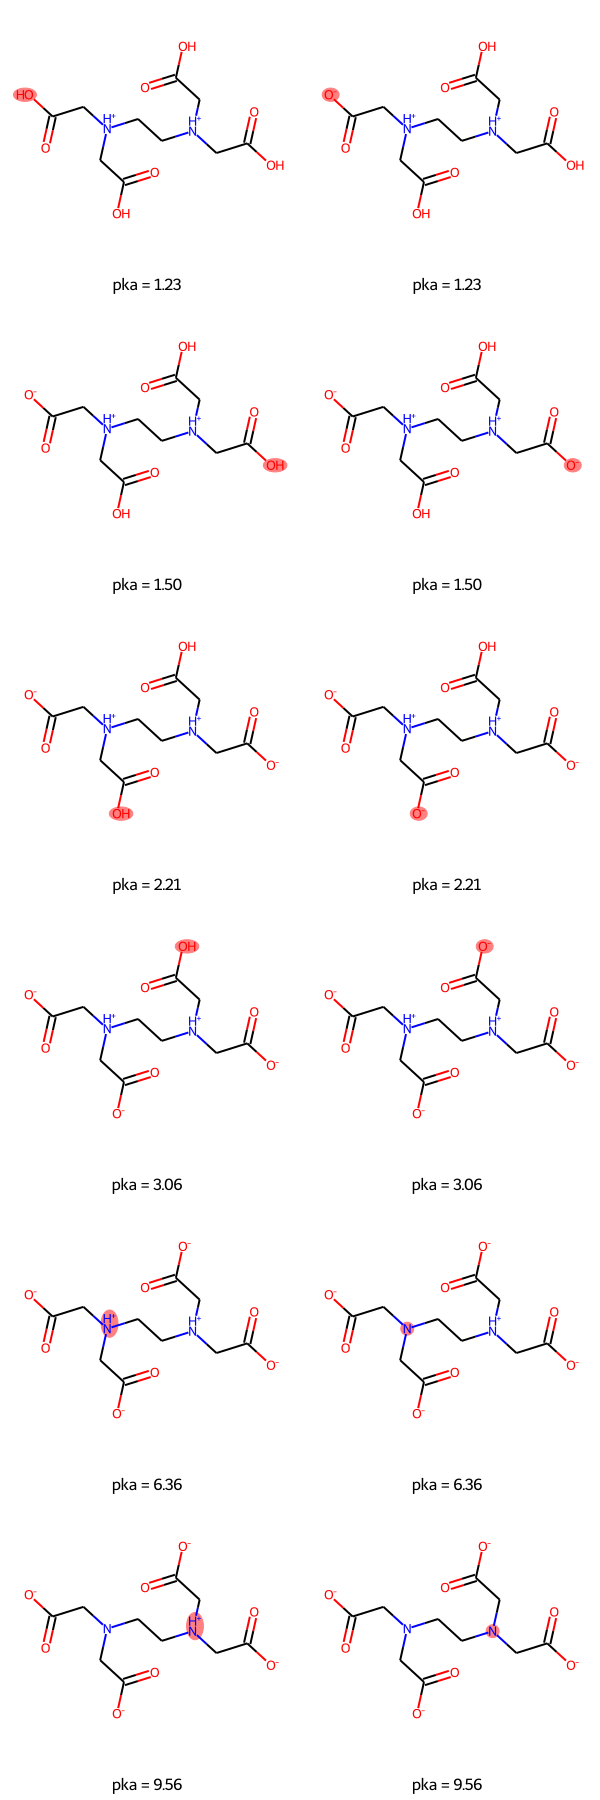

In [24]:
draw_pairs = [] 
pair_atoms = []
pair_pkas = []
for i in range(len(mols)-1):
    draw_pairs.extend([mols[i], mols[i+1]])
    pair_atoms.extend([[atoms[i]], [atoms[i]]])
    pair_pkas.extend([pkas[i], pkas[i]])
Draw.MolsToGridImage(draw_pairs, molsPerRow=2, subImgSize=(300, 300), highlightAtomLists=pair_atoms, legends=[f"pka = {pair_pkas[i]:.2f}" for i in range(12)])